In [3]:
import os
import math
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import numpy 
from scipy import optimize
from matplotlib import pyplot
%matplotlib inline
import aplpy
from scipy import integrate

from header_utils import verify_header



<h2> Open data file 

In [4]:

ROOTfile = "./Crab_LZA_excess_uncorr.fits"
HDUlist = fits.open(ROOTfile)
HDUlist.info()
gal_wcs = WCS(HDUlist[0].header)
print(HDUlist[1].header)
print(gal_wcs)
HDUlist.close()


Filename: ./Crab_LZA_excess_uncorr.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      17   ()              
1    UncorrelatedExcess  ImageHDU        18   (259, 259)   float32   


XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  259 / length of data axis 1                          NAXIS2  =                  259 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'UncorrelatedExcess' / Extension name                                 RADECSYS= 'FK5     '           / WCS for this file                              EQUINOX =                2000. / Epoch of coordinate system                     CTYPE1  = 'RA---TAN'           / Axis type for dim 1 (RA)                       CRVAL1  =       83.63333046211 / Sky coord of 1st axis (deg)                    CRPIX1  =                 129. / Referen

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:Auto-setting vmin to -1.487e+00
INFO:astropy:Auto-setting vmax to  7.629e+00
/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.
/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


INFO: Auto-setting vmin to -1.487e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.629e+00 [aplpy.core]


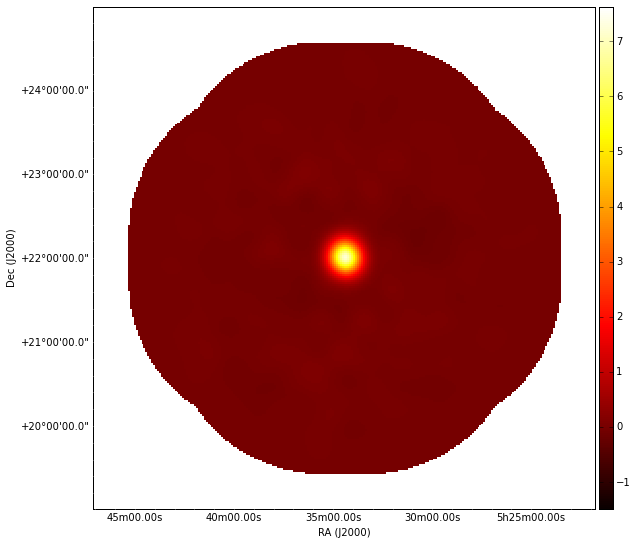

In [5]:
fig_apl = aplpy.FITSFigure(ROOTfile)
fig_apl.show_colorscale(cmap='hot',smooth=5)
col_bar = fig_apl.show_colorbar()
#col_bar


In [6]:
skymap_data, skymap_header = fits.getdata(ROOTfile, header = True)

excess_data_N = numpy.nan_to_num(skymap_data) # rm nan's for fitting 


<h2> Create coordinate arrays

In [7]:
x_bins = skymap_data.shape[0]
y_bins = skymap_data.shape[1]

# Create x and y indices
x = numpy.linspace(0, x_bins-1, x_bins)
y = numpy.linspace(0, y_bins-1, y_bins)
x, y = numpy.meshgrid(x, y)
coords = x, y

x_world, y_world = fig_apl.pixel2world(x,y)
coords_world = x_world, y_world

print(fig_apl.world2pixel(83.6296,22.014)) # Crab


(129.14929118926517, 128.97964846247766)


<h2> Fitting Central Gaussian

In [14]:

#Crab_bounds = {'x_mean':(115,117),'y_mean':(115,117)}
Crab_gauss = models.Gaussian2D(amplitude=25,x_mean=129,y_mean=129,x_stddev=2.,y_stddev=2.)

fit_p = fitting.LevMarLSQFitter()
fit_gauss = fit_p(Crab_gauss, x, y, excess_data_N, maxiter=2500)

print(fit_gauss.parameters)


[  29.75144215  129.36229733  129.18445734    2.51225373    3.10032611
    0.43530515]


In [17]:
Crab_gauss_1 = models.Gaussian2D(amplitude=20,x_mean=129,y_mean=129,x_stddev=1.,y_stddev=1.)
Crab_gauss_2 = models.Gaussian2D(amplitude=10,x_mean=129,y_mean=129,x_stddev=3.,y_stddev=3.)
Crab_gauss_sum = Crab_gauss_1 + Crab_gauss_2 

sum_fit = fitting.LevMarLSQFitter()
fit_sum = sum_fit(Crab_gauss_sum, x, y, excess_data_N, maxiter=2500)

print(fit_sum.parameters)


[  19.13767153  129.35626546  129.30010117    1.36549988    1.57204202
    0.38227702   17.54881262  129.38076462  129.1048363     3.11391799
    3.94298971    0.3917093 ]


In [9]:

print(fig_apl.pixel2world(fit_gauss.x_mean.value,fit_gauss.y_mean.value))

stddevs = fig_apl.pixel2world(fit_gauss.x_stddev.value,fit_gauss.y_stddev.value)


(83.624276992053566, 22.018744463701481)


In [18]:
pointsource_filename = "./Crab_gaussian_source.fits"
pointsource_excess = fit_sum(x,y)

if not os.path.exists(pointsource_filename):
    fits.writeto(pointsource_filename, pointsource_excess, skymap_header, clobber=True)


35.490133675363253

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


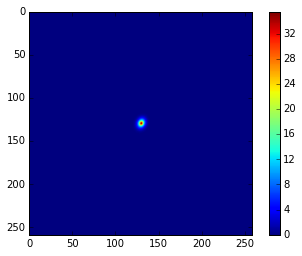

In [19]:
fig_smoothed = pyplot.figure()
pyplot.imshow(numpy.nan_to_num(pointsource_excess))
pyplot.colorbar()
numpy.nanmax(pointsource_excess)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


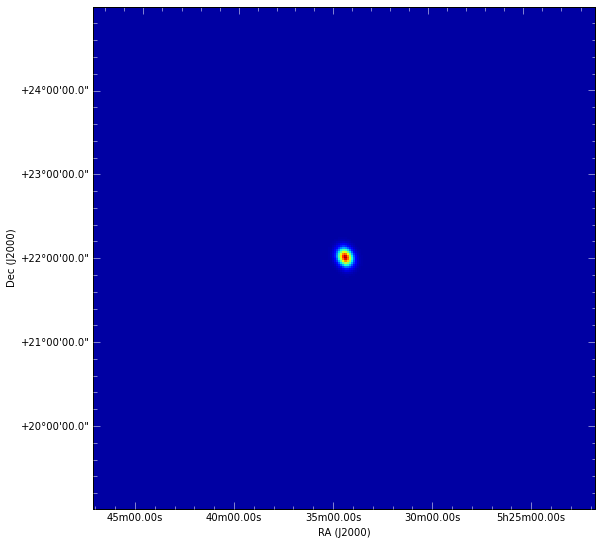

In [20]:
fig_apl = aplpy.FITSFigure(pointsource_filename)
fig_apl.show_colorscale(vmin=-1,vmax=30)


<h2> Excess after subtraction of central sources

In [22]:
residual_excess = skymap_data - pointsource_excess 

subtracted_filename = "./Crab_subtracted.fits"

#if not os.path.exists(pointsource_filename):
fits.writeto(subtracted_filename, numpy.nan_to_num(residual_excess), skymap_header, clobber=True)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


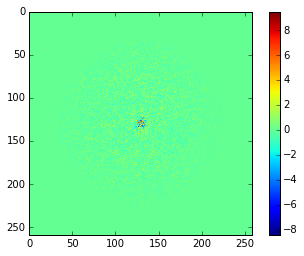

In [23]:
fig_smoothed = pyplot.figure()
pyplot.imshow(numpy.nan_to_num(residual_excess))
numpy.nanmax(residual_excess)
pyplot.colorbar()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:Auto-setting vmin to -1.081e+00
INFO:astropy:Auto-setting vmax to  2.741e+00


INFO: Auto-setting vmin to -1.081e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.741e+00 [aplpy.core]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


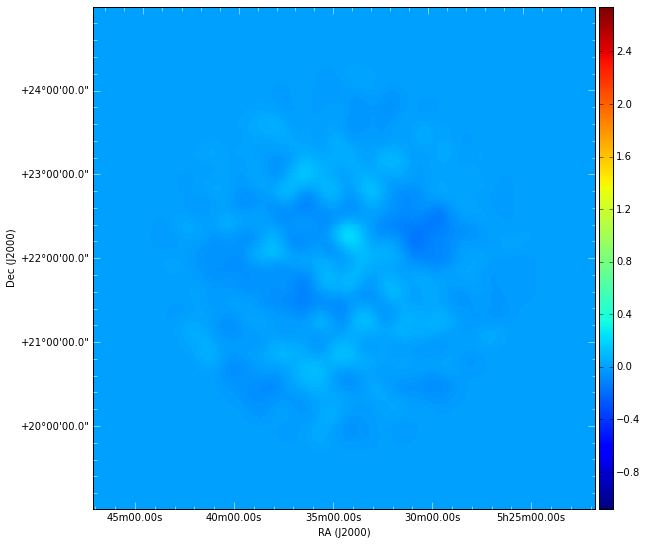

In [24]:
fig_subtracted = aplpy.FITSFigure(subtracted_filename)
fig_subtracted.show_colorscale(smooth=5)
fig_subtracted.show_colorbar()


<h2> Gaussian Smoothing the Residual

In [ ]:
smooth_stddev = (x_bins/4.0)*0.2 # degrees to bins
smoothed_residual_excess = numpy.array(residual_excess, dtype=numpy.float128)

for i in range(0,x_bins):
    for j in range(0,y_bins):
        #print(residual_excess[i,j],end="")
        if math.isinf(residual_excess[i,j]):
            print("inf: %d,%d" % (i,j))
           
        
print(residual_excess[129,129])
        

In [ ]:
smooth_stddev = (x_bins/4.0)*0.2 # degrees to bins
smoothed_residual_excess = numpy.array(residual_excess, dtype=numpy.float128)

for i in range(0,x_bins):
    for j in range(0,y_bins):
        #print(residual_excess[i,j],end="")
        if not math.isnan(residual_excess[i,j]) and not math.isinf(residual_excess[i,j]):
            #print("%d,%d" % (i,j))
            point_gauss = models.Gaussian2D(amplitude=residual_excess[i,j],x_mean=i,y_mean=j,x_stddev=smooth_stddev,y_stddev=smooth_stddev)
            smoothed_residual_excess += point_gauss(x,y)
            del point_gauss
        

In [ ]:
smoothed_residual_excess_N = numpy.nan_to_num(smoothed_residual_excess)
smoothed_residual_excess_F = numpy.array(smoothed_residual_excess_N, dtype=numpy.float)
print(smoothed_residual_excess_F)
print(smoothed_residual_excess_F[129,129])

fig_smoothed = pyplot.figure()
pyplot.imshow(smoothed_residual_excess_F)



In [ ]:
def symmetric_2d_gaussian(x, y, amp, x0, y0, sigma):
    g = amp*numpy.exp(-((x-x0)**2+(y-y0)**2)/(2*sigma**2))
    return g


In [ ]:
x_max = fig_apl.pixel2world(0,y_bins/2)[0]
x_min = fig_apl.pixel2world(x_bins,y_bins/2)[0]
delta_x = x_max - x_min
print(delta_x)

y_min = fig_apl.pixel2world(x_bins/2,0)[1]
y_max = fig_apl.pixel2world(x_bins/2,y_bins)[1]
delta_y = y_max - y_min
print(y_max-y_min)

sigma = 0.2
sigma_bins = sigma/delta_y * x_bins 
print(sigma_bins)


In [ ]:
amplitude = 1
x_lower = -0.5
x_upper = 0.5
area = integrate.dblquad(symmetric_2d_gaussian, x_lower, x_upper, lambda y_lower: -0.5, lambda y_upper: 0.5, args=(amplitude,0,0,sigma_bins))

area2 = integrate.dblquad(symmetric_2d_gaussian, x_lower, x_upper, lambda y_lower: -0.5, lambda y_upper: 0.5, args=(amplitude,0,0,1))
area3 = integrate.dblquad(symmetric_2d_gaussian, x_lower, x_upper, lambda y_lower: -0.5, lambda y_upper: 0.5, args=(amplitude,0,0,8))


In [ ]:
x = lambda y: 5
print(x)
print(sigma_bins)
print(area)
print(area2)
print(area3)


<h2> create symmetric gaussian kernel

In [ ]:
sig = 8
n_dim = 35 # should be odd and greater than 1 
gauss_kernel = numpy.zeros((n_dim, n_dim))

#coord_range = range(math.ceil(-n_dim/2),math.ceil(n_dim/2))
kernel_range = range(0, n_dim)

for i in kernel_range:
    for j in kernel_range:
        area = integrate.dblquad(symmetric_2d_gaussian,i,i+1,lambda yl:j,lambda yu:j+1,(1,n_dim/2,n_dim/2,sig))
        gauss_kernel[i, j] = area[0]
        
print(gauss_kernel)
d = math.floor(n_dim/2)


In [ ]:
residual_excess_n = numpy.nan_to_num(residual_excess)
smoothed_residual_excess_conv = numpy.zeros((residual_excess_n.shape))

for i in range(d,residual_excess_n.shape[0]-d):
    for j in range(d,residual_excess_n.shape[1]-d):
        # sum over the other cells 
        for ip in kernel_range:
            for jp in kernel_range: 
                smoothed_residual_excess_conv[i,j] += gauss_kernel[ip,jp] * residual_excess_n[i+d-ip,j+d-jp]
                
                


In [ ]:
fig_custom = pyplot.figure()
pyplot.imshow(smoothed_residual_excess_conv)
pyplot.colorbar()


fix header

In [ ]:
print(type(HDUlist[0].header))
fixed_header = HDUlist[1].header.copy()
fixed_header['RADECSYS']
verify_header(fixed_header)


<h2> King Function

In [25]:
models.custom_model?

In [27]:
def KingFunction(x, sigma, gamma):
    K = 1/(2*math.pi*sigma**2)*(1-1/gamma)*math.pow((1+1/(2*gamma)*x**2/sigma**2),-gamma)
    return K


In [30]:
king_custom = models.custom_model(func=KingFunction)
